In [1]:
import pandas as pd
import matplotlib.pyplot as plt

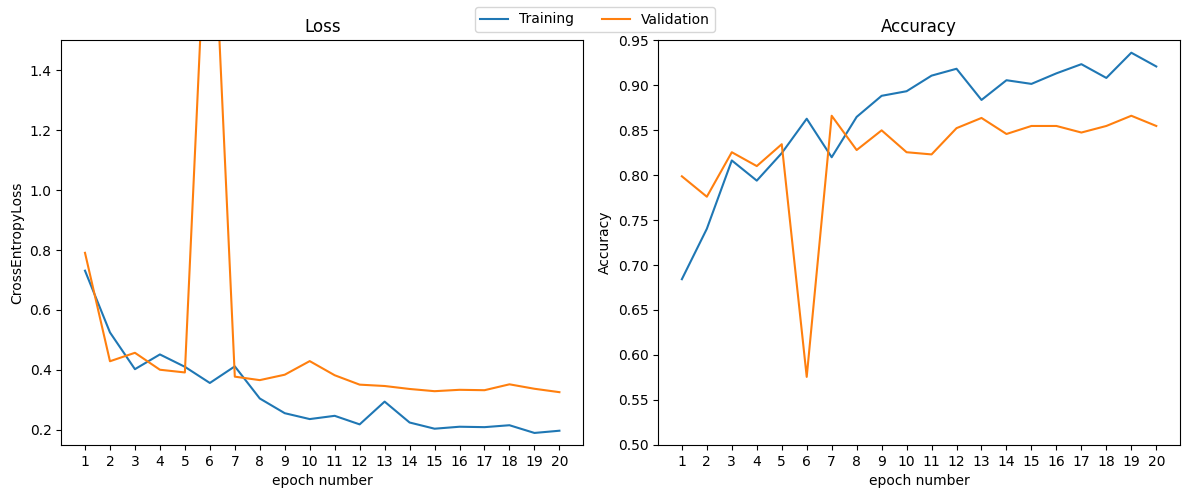

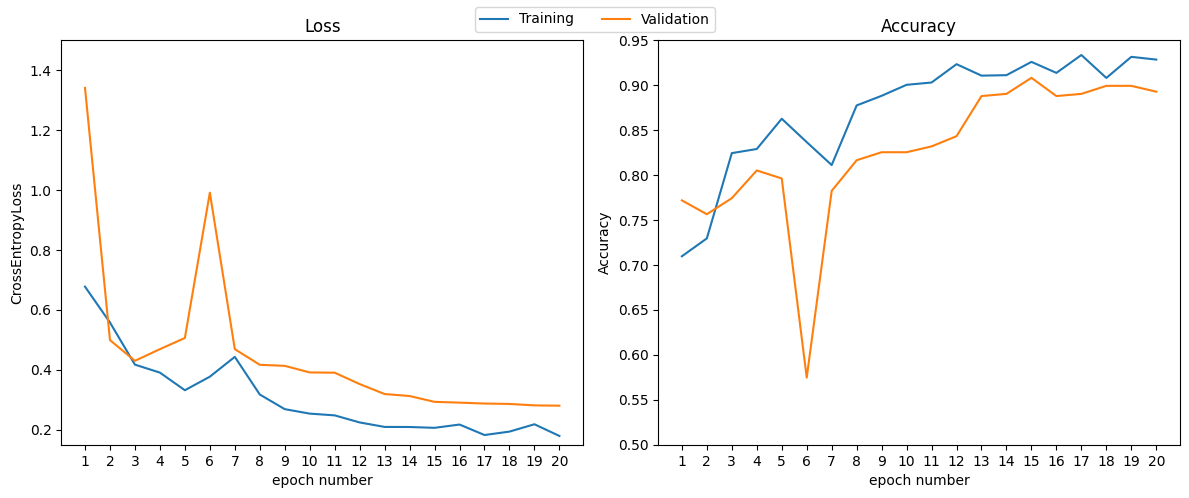

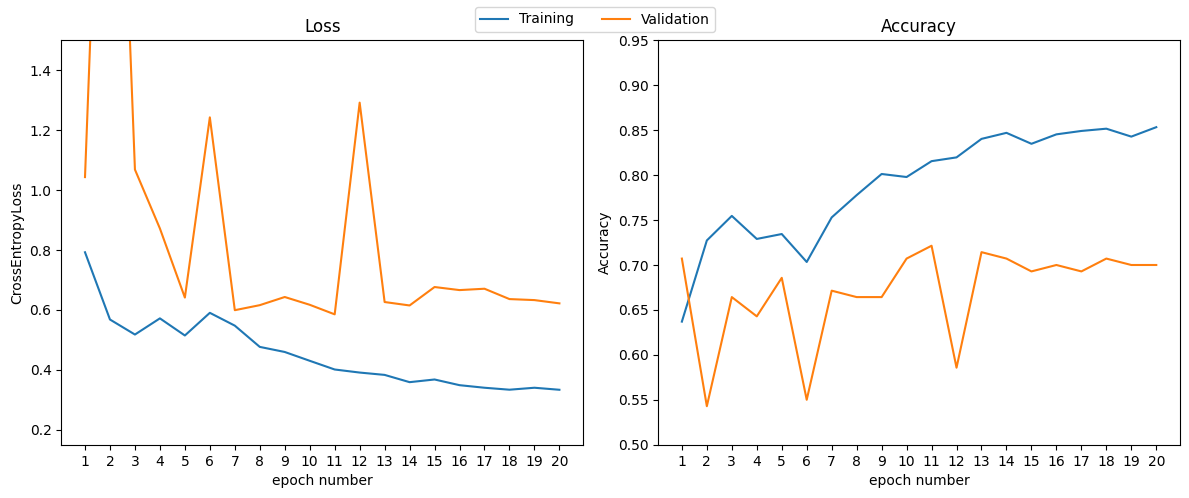

In [5]:
model_names = ['densenet121_e20_s300_b14', 'densenet121_prep_e20_s300_b14', 'densenet121_vessel_e20_s300_b14']
for nm_model in model_names:
    df = pd.read_csv('models/'+nm_model+'_stats.csv')
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.setp((ax1,ax2), xticks=range(len(df['epoch number'])))
    ax1.plot(df['epoch number'],df['train loss'], label='Training')
    ax1.plot(df['epoch number'],df['validation loss'], label='Validation')
    ax1.set_title("Loss")
    ax1.set_ylim([.15, 1.5])
    ax1.set_ylabel('CrossEntropyLoss')
    ax1.set_xlabel('epoch number')
    plt.xticks(range(len(df['epoch number'])))
    ax2.plot(df['epoch number'],df['train accuracy'])
    ax2.plot(df['epoch number'],df['validation accuracy'])
    ax2.set_title("shares x with main")
    ax2.set_title("Accuracy")
    ax2.set_ylim([.5, .95])
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('epoch number')
    fig.tight_layout()
    fig.legend(*ax1.get_legend_handles_labels(),
                loc='upper center', ncol=4)
    plt.savefig('models/'+nm_model+'_plot.jpg')

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import segmentation_models_pytorch as smp
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import warnings

c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
img_size = (300, 300)

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def test_model(model):    
    was_training = model.training
    model.eval()
    metric_monitor = MetricMonitor()

    for i, data in enumerate(dataloaders['test'], 0):
        samples, labels = data
        with torch.no_grad():
            
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            _, preds = torch.max(output, 1)
            tn, fp, fn, tp = confusion_matrix(labels.cpu(), preds.cpu(), labels=[0, 1]).ravel()
            
            f1_score = (2*tp)/(2*tp+fp+fn)
            accuracy = (tp+tn)/(tp+tn+fp+fn)
            recall = (tp)/(tp+fn)
            precision = (tp)/(tp+fp)
            
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("f1 score", f1_score)
            metric_monitor.update("accuracy", accuracy)
            metric_monitor.update("recall", recall)
            metric_monitor.update("precision", precision)

            torch.cuda.empty_cache()
            model.train(mode=was_training)

    print('Testing {} %'.format(metric_monitor))



Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0


In [32]:
warnings.filterwarnings('ignore')
for nm_name in ['models/densenet121_e20_s300_b14', 'models/densenet121_prep_e20_s300_b14', 'models/densenet121_vessel_e20_s300_b14']:
    if nm_model.split('_')[2] == 'prep':
        data_dir = './data/data_m_prep'
    elif nm_model.split('_')[2] == 'vessel':
        data_dir = './data/data_m_vessel'
    else:
        data_dir = './data/data_m'
    
    image_datasets = {'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test']) }
    dataloaders = {'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=4)}
    dataset_sizes = {'test': len(image_datasets['test'])}
    class_names = image_datasets['test'].classes

    model_ft.load_state_dict(torch.load(nm_model+'.pt'))

    test_model(model_ft)

Testing Loss: 0.384 | f1 score: 0.810 | accuracy: 0.814 | recall: 0.823 | precision: 0.818 %
Testing Loss: 0.455 | f1 score: 0.805 | accuracy: 0.800 | recall: 0.828 | precision: 0.806 %
Testing Loss: 0.435 | f1 score: 0.815 | accuracy: 0.814 | recall: 0.853 | precision: 0.802 %


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import segmentation_models_pytorch as smp
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import warnings
from PIL import Image
def imgshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3998, 0.1676, 0.0636])
    std = np.array([0.2762, 0.1356, 0.0666])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

img_size = (300, 300)
batch_size = 14
model_name = 'densenet121'
learning_rate = 0.001
num_epochs=20
nm_model = f'models/{model_name}_e{num_epochs}_s{img_size[0]}_b{batch_size}'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
    ])
}

data_dir = './data/data_m'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

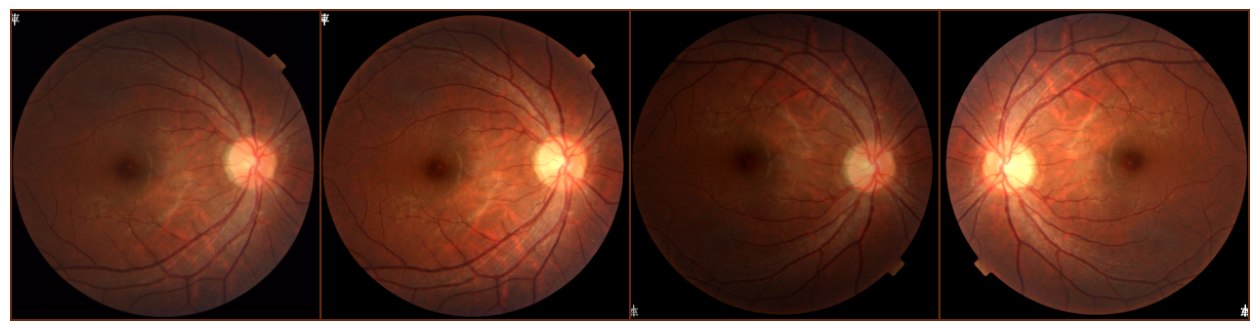

In [56]:
image_path = './data/data_m/train/control/171_N.png'
image = Image.open(image_path)
samples = []
samples.append(transforms.Compose(
    [transforms.Resize(img_size),transforms.ToTensor(),
     transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
     ])(image))
samples.append(data_transforms['train'](image))
samples.append(data_transforms['train'](image))
samples.append(data_transforms['train'](image))

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
imgshow(grid_imgs)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('morphological_data/morph_stats_test.csv', index_col=0)
data = data.drop('image_name', axis=1)
data = data.drop('prob_0', axis=1)
data = data.drop('prob_1', axis=1)
data = data.astype({'status': 'int32', 'pred_status': 'int32'})
col_names = data.columns.values.tolist()[1:]
col_names.append(data.columns.values.tolist()[0])
data = data[col_names]
data = data.reindex(columns=col_names)
data.columns

Index(['area', 'endpoints', 'intersection_points', 'median_tortuosity',
       'tortuosity_index', 'length', 'perimeter', 'BA_mean', 'BA_std',
       'BA_median', 'D0', 'D1', 'D2', 'SL', 'pred_status', 'status'],
      dtype='object')

C:\Users\micha\AppData\Local\Temp\ipykernel_4696\874881602.py:52: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


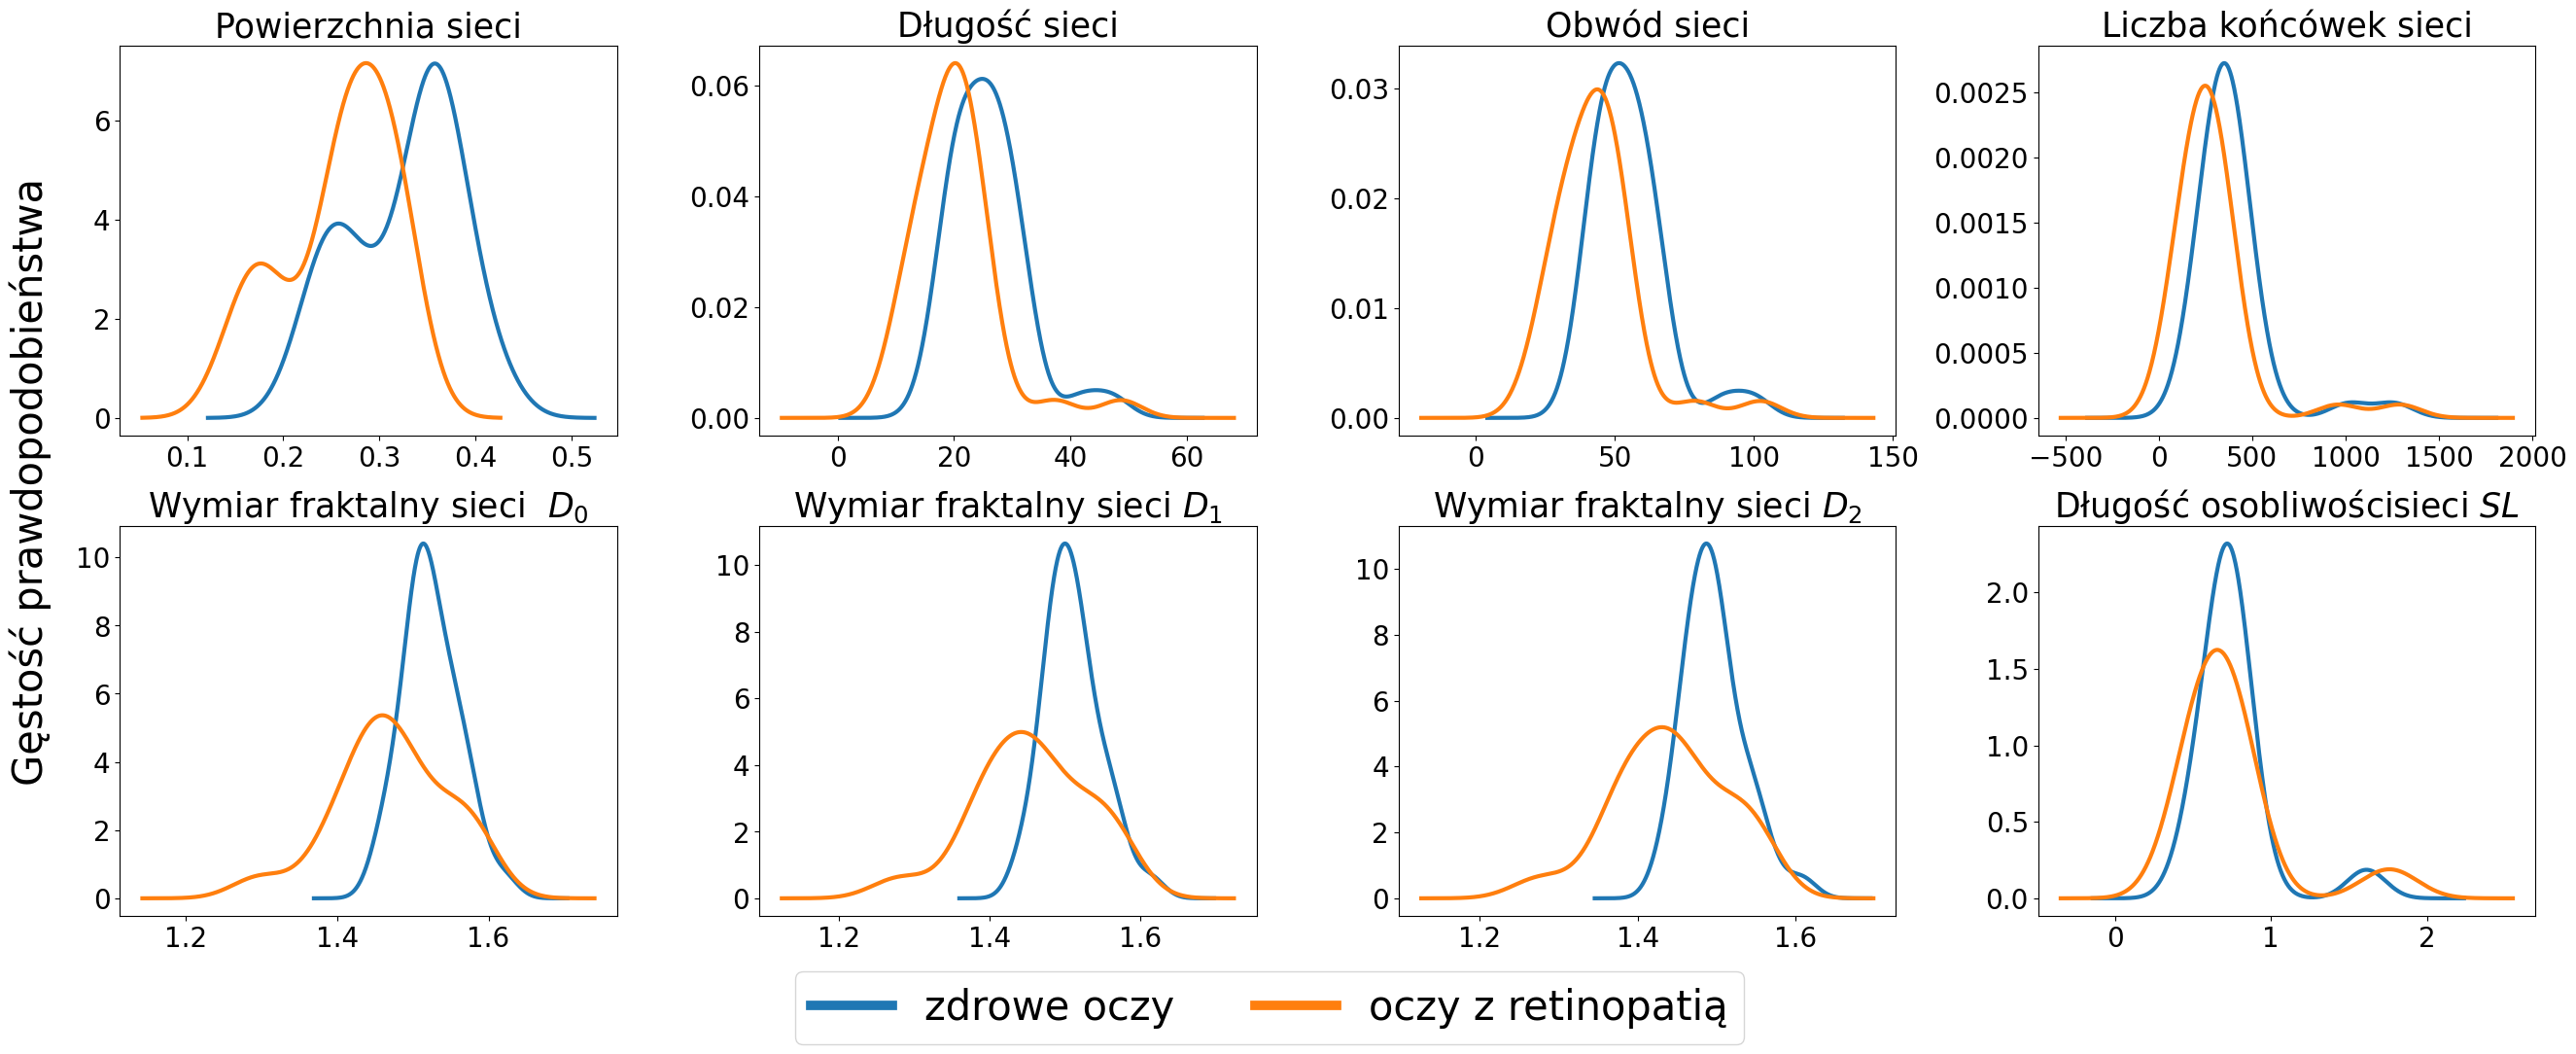

In [151]:
fig, ax = plt.subplots(2, 4, figsize=(27,10))
data.loc[data['status'] == 0, 'area'].plot.kde(ax=ax[0,0], linewidth=3)
data.loc[data['status'] == 1, 'area'].plot.kde(ax=ax[0,0], linewidth=3)
ax[0,0].yaxis.label.set_visible(False)
ax[0,0].set_title('Powierzchnia sieci', fontsize=25)
ax[0,0].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'length'].plot.kde(ax=ax[0,1], linewidth=3)
data.loc[data['status'] == 1, 'length'].plot.kde(ax=ax[0,1], linewidth=3)
ax[0,1].yaxis.label.set_visible(False)
ax[0,1].set_title('Długość sieci', fontsize=25)
ax[0,1].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'perimeter'].plot.kde(ax=ax[0,2], linewidth=3)
data.loc[data['status'] == 1, 'perimeter'].plot.kde(ax=ax[0,2], linewidth=3)
ax[0,2].yaxis.label.set_visible(False)
ax[0,2].set_title('Obwód sieci', fontsize=25)
ax[0,2].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'intersection_points'].plot.kde(ax=ax[0,3], linewidth=3)
data.loc[data['status'] == 1, 'intersection_points'].plot.kde(ax=ax[0,3], linewidth=3)
ax[0,3].yaxis.label.set_visible(False)
ax[0,3].set_title('Liczba końcówek sieci', fontsize=25)
ax[0,3].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'D0'].plot.kde(ax=ax[1,0], linewidth=3)
data.loc[data['status'] == 1, 'D0'].plot.kde(ax=ax[1,0], linewidth=3)
ax[1,0].yaxis.label.set_visible(False)
ax[1,0].set_title('Wymiar fraktalny sieci  $D_{0}$', fontsize=25)
ax[1,0].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'D1'].plot.kde(ax=ax[1,1], linewidth=3)
data.loc[data['status'] == 1, 'D1'].plot.kde(ax=ax[1,1], linewidth=3)
ax[1,1].yaxis.label.set_visible(False)
ax[1,1].set_title('Wymiar fraktalny sieci $D_{1}$', fontsize=25)
ax[1,1].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'D2'].plot.kde(ax=ax[1,2], linewidth=3)
data.loc[data['status'] == 1, 'D2'].plot.kde(ax=ax[1,2], linewidth=3)
ax[1,2].yaxis.label.set_visible(False)
ax[1,2].set_title('Wymiar fraktalny sieci $D_{2}$', fontsize=25)
ax[1,2].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'SL'].plot.kde(ax=ax[1,3], label='zdrowe oczy', linewidth=3)
data.loc[data['status'] == 1, 'SL'].plot.kde(ax=ax[1,3],label='oczy z retinopatią', linewidth=3)
ax[1,3].yaxis.label.set_visible(False)
ax[1,3].set_title('Długość osobliwościsieci $SL$', fontsize=25)
ax[1,3].tick_params(labelsize=20)

fig.supylabel('Gęstość prawdopodobieństwa\n', fontsize=30)
leg = fig.legend(['zdrowe oczy', 'oczy z retinopatią'], loc='lower center', ncol=2, fontsize=30, bbox_to_anchor=(0.5, -0.1))
for legobj in leg.legendHandles:
    legobj.set_linewidth(7)
plt.tight_layout()

In [160]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0


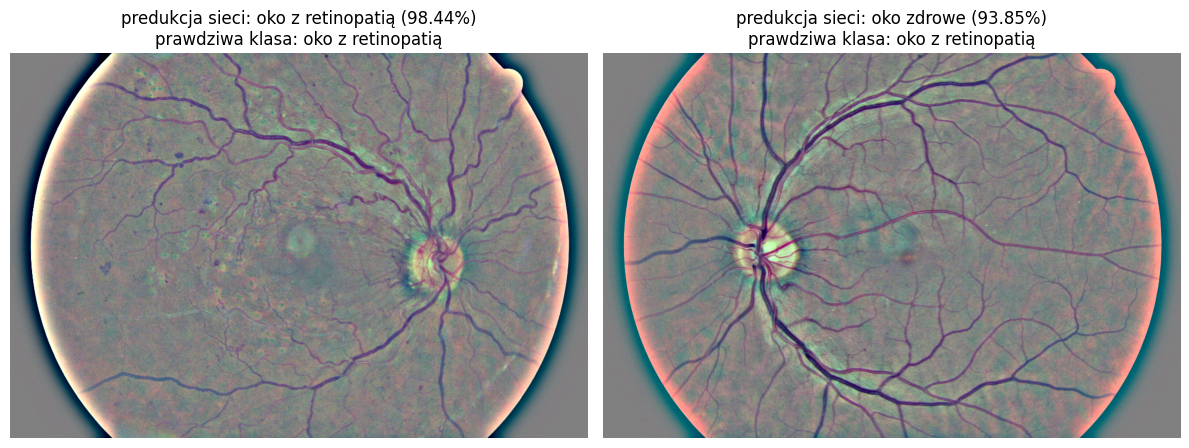

In [187]:
model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  2))
model_ft.load_state_dict(torch.load('models/densenet121_prep_e20_s300_b14.pt'))
model_ft.to('cuda')
model_ft.eval()

img_size=(300,300)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5023, 0.5017, 0.5019], [0.1245, 0.0934, 0.0581])
    ])
}

paths = ["data/data_m_prep/test/retina/09_dr.png", "data/data_m_prep/test/retina/10_dr.png"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i, pathImageFile in enumerate(paths):
    
    if pathImageFile.split('/')[3]=='control':
        true_leb = 'oko zdrowe'
    else:
        true_leb = 'oko z retinopatią'
    
    imageData = Image.open(pathImageFile).convert('RGB')
    imageDataN = data_transforms['test'](imageData)
    imageDataN = imageDataN.unsqueeze_(0).cuda()
    output = model_ft(imageDataN)
    sm = nn.Softmax(dim=1)
    prop = round((sm(output)[0][torch.max(output,1)[1]]).item()*100,2)
    classes = ['oko zdrowe', 'oko z retinopatią']
    label = classes[torch.max(output,1)[1]] + ' (' + str(prop) + '%)'
    if i in (0,1):  ind1=0
    else: ind1=1
    if i in (0,2): ind2=0
    else: ind2=1
    ax[ind2].imshow((imageData ))
    ax[ind2].set_title('predukcja sieci: '+label+('\nprawdziwa klasa: '+true_leb))
    ax[ind2].axis("off")
    plt.tight_layout()

In [186]:
for i, pathImageFile in enumerate(glob.glob('data/data_m_prep/test/control/*')+glob.glob('data/data_m_prep/test/retina/*')):
    
    if pathImageFile.split('\\')[0].split('/')[3]=='control':
        true_leb = 'oko zdrowe'
    else:
        true_leb = 'oko z retinopatią'
    
    imageData = Image.open(pathImageFile).convert('RGB')
    imageDataN = data_transforms['test'](imageData)
    imageDataN = imageDataN.unsqueeze_(0).cuda()
    output = model_ft(imageDataN)
    sm = nn.Softmax(dim=1)
    prop = round((sm(output)[0][torch.max(output,1)[1]]).item()*100,2)
    classes = ['oko zdrowe', 'oko z retinopatią']
    label = classes[torch.max(output,1)[1]]
    if label != true_leb: print(i, pathImageFile, label, true_leb)

30 data/data_m_prep/test/retina\10_dr.png oko zdrowe oko z retinopatią
32 data/data_m_prep/test/retina\192_D.png oko zdrowe oko z retinopatią
51 data/data_m_prep/test/retina\aria_d_17_12.png oko zdrowe oko z retinopatią
52 data/data_m_prep/test/retina\aria_d_22_22.png oko zdrowe oko z retinopatią
54 data/data_m_prep/test/retina\aria_d_24_21.png oko zdrowe oko z retinopatią
